## Semi-Supervised Parameter Estimation

This notebook contains code to reproduce the results of our work on 
"Enhanced Human-Machine Interaction by Combining Proximity Sensing with Global Perception"

This code requires `numpy`, `scipy`, `sklearn`, `matplotlib`, `pytorch`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import naive as naive # See `naive.py` next to notebook file

import warnings
warnings.filterwarnings("ignore")

In [2]:
NUM_CAT_BINS = 4
CAT_XYRANGE = [[-5,5], [-1,3]]

In [3]:
def preprocess(samples):
    '''Preprocess sensor data.
    Corrects invalid sensor readings and computes 1D bin coordinates for xy-positions.'''
    
    # Add bin coordinates for xy positions
    h = naive.Histogram(num_bins=NUM_CAT_BINS, xyrange=CAT_XYRANGE)
    b = h.bin_coords1d(samples[:, 1:3])
    num_bins = h.H.shape[0]*h.H.shape[1]
    
    samples = np.hstack((samples[:, :-1], b.reshape(-1, 1), samples[:, -1].reshape(-1,1)))
    
    # Remove incorrect sensor readings
    samples[:, 0] = np.clip(samples[:, 0], 1e-6, 1-1e-6)
    
    return samples # Batch x [Confidence, X, Y, CosAngle, Bin, C]

In [4]:
train_samples = preprocess(np.load('train_c.npy'))
test_samples = preprocess(np.load('test.npy'))
train_samples.shape, test_samples.shape

((4500, 6), (5000, 6))

In [5]:
from sklearn.model_selection import ShuffleSplit

def split(samples, frac_fully=0.1, frac_partially=None, num_splits=5):
    '''Split data multiple times into fully and partially observed sets'''
    
    if frac_partially is None:
        frac_partially = 1 - frac_fully
        
    sp = ShuffleSplit(
        n_splits=num_splits, 
        train_size=frac_fully, 
        test_size=frac_partially)
    
    return sp.split(samples)
    

Naive Bayes classification.

In [6]:
class NaiveBayes:
    '''Naive Bayes for classification. 
    See section II.D of our publication '''
    def __init__(self):
        pass
    
    def fit(self, samples):
        '''Fit based on maximum likelihood assuming all samples are fully observed.'''
        mask = samples[:, -1] == 1
        tp = samples[mask]
        tn = samples[~mask]
        
        self.c = naive.Bernoulli.fit(mask)
        self.fg = [naive.Beta.fit(tp[:, 0]), naive.Beta.fit(tn[:, 0])]
        self.fxy = [naive.Categorical2d.fit(tp[:, 1:3], num_bins=NUM_CAT_BINS, xyrange=CAT_XYRANGE), 
                    naive.Categorical2d.fit(tn[:, 1:3], num_bins=NUM_CAT_BINS, xyrange=CAT_XYRANGE)]
        self.fo = [naive.Normal.fit(tp[:,3]), naive.Normal.fit(tn[:,3])] # 0..1 range   
        
    def set_from_torch(self, params):
        '''Set parameters from torch optimization.'''
        theta, a, b, mu, sigma, alpha = [p.detach().numpy() for p in params] 
        self.c = naive.Bernoulli(np.asscalar(theta))
        self.fg = [naive.Beta(a[0], b[0]), naive.Beta(a[1], b[1])]
        self.fxy = [naive.Categorical2d(naive.Histogram(H=alpha[0], num_bins=NUM_CAT_BINS, xyrange=CAT_XYRANGE)), 
                    naive.Categorical2d(naive.Histogram(H=alpha[1], num_bins=NUM_CAT_BINS, xyrange=CAT_XYRANGE))]
        self.fo = [naive.Normal(mu[0], sigma[0]**2), naive.Normal(mu[1], sigma[1]**2)]
        
    def classify(self, x):
        '''Classify the samples in rows of x.'''
        x = np.asarray(x)
        N = x.shape[0]
        
        pos = self.c.pdf(np.ones(N)) * self.fg[0].pdf(x[:,0]) * self.fxy[0].pdf(x[:,1:3]) * self.fo[0].pdf(x[:,3])
        neg = self.c.pdf(np.zeros(N)) * self.fg[1].pdf(x[:,0]) * self.fxy[1].pdf(x[:,1:3]) * self.fo[1].pdf(x[:,3])
        
        return pos / (pos + neg)
    
    def __repr__(self):
        return f'NaiveBayes(C={self.c}, Fg={self.fg[0]}/{self.fg[1]}, Fxy={self.fxy[0]}/{self.fxy[1]}, Fo={self.fo[0]}/{self.fo[1]})'
    

### Semi-supervised training

In [7]:
import torch
import torch.distributions as d
import torch.distributions.constraints as constraints
import torch.optim as optim

We optimize parameters $\Omega$ in an unconstrained real domain. The following transforms either transform from or to this domain.

In [8]:
zeroone_t = d.transform_to(constraints.interval(0, 1)) # -inf,inf -> 0,1
gt_t = d.transform_to(constraints.greater_than(0)) # -inf,inf -> >0
simplex_t = d.transform_to(d.constraints.simplex)  # {R_i} -> sum({R_i})=1, R_i>=0

def transform(unconstrained_params):
    '''Transform from unconstrained domain to constrained parameter domain.'''
    theta, a, b, mu, sigma, alpha = unconstrained_params
    theta = zeroone_t(theta)
    a = gt_t(a) 
    b = gt_t(b) 
    sigma = gt_t(sigma) 
    alpha = torch.stack([
        simplex_t(alpha[0]),
        simplex_t(alpha[1]),
    ], 0)
    return theta, a, b, mu, sigma, alpha

def inv_transform(constrained_params):
    '''Transform from constrained parameter domain to unconstrained.'''
    theta, a, b, mu, sigma, alpha = constrained_params
    theta = zeroone_t.inv(theta)
    a = gt_t.inv(a)
    b = gt_t.inv(b)
    sigma = gt_t.inv(sigma)
    alpha = torch.stack([
        simplex_t.inv(alpha[0]),
        simplex_t.inv(alpha[1]),
    ], 0)
    return theta, a, b, mu, sigma, alpha

In [9]:
def log_joint(unconstrained_params, f):
    '''Compute the log joint probability of our model (eq. 2).
    
    Params
        unconstrained_params: $\Omega$ in unconstrained domain
        f: Nx [Confidence, X, Y, CosAngle, Bin] observations.
    
    Returns
        Nx2 array containing the log joint probability table computed for
        both values of C in the last dimensions (index 0: c=1, index 1: c=0)
    '''
    theta, a, b, mu, sigma, alpha = transform(unconstrained_params)    
    
    bernoulli = d.Bernoulli(probs=theta)
    betae = [d.Beta(a[0], b[0]), d.Beta(a[1], b[1])]                 # p(f_g|c=1), p(f_g|c=0)   
    normals = [d.Normal(mu[0], sigma[0]), d.Normal(mu[1], sigma[1])] # p(f_o|c=1), p(f_o|c=0)   
    cats = [d.Categorical(alpha[0]), d.Categorical(alpha[1])]        # p(f_xy|c=1), p(f_xy|c=0)   
        
    cs = [torch.ones(f.shape[0]), torch.zeros(f.shape[0])]    
    lj = [bernoulli.log_prob(c) + 
          beta.log_prob(f[:, 0]) + 
          normal.log_prob(f[:, 3]) + 
          1e-2*cat.log_prob(f[:, 4].type(torch.long)) 
              for c,beta,normal,cat in zip(cs, betae, normals, cats)]
    
    return torch.stack(lj, -1) # Nx2    

def q(lj):
    '''E-Step of EM algorithm (eq. 4)
    
    Params
        lj: Nx2 array containing log joint probabilities
    
    Returns
        Nx2 array containing p(C_i | F_i, Omega^t)   
    '''
    j = torch.exp(lj)
    s = j[:, 0] + j[:, 1]
    return j / s[:, None] # Nx2 with c=1 at index 0, c=0 at index 1

In [38]:
def em_bfgs(fo, po, initial_params):
    from scipy.optimize import minimize
    
    fo, po = torch.from_numpy(fo).type(torch.float32), torch.from_numpy(po).type(torch.float32)
    balance = (fo.shape[0] + 1) / (po.shape[0] + 1)
    
    def flatten(params):
        flat = np.concatenate([p.view(-1).numpy() for p in params])
        return flat

    def unflatten(params):
        theta = torch.from_numpy(params[0:1]).type(torch.float32)
        a = torch.from_numpy(params[1:3]).type(torch.float32)
        b = torch.from_numpy(params[3:5]).type(torch.float32)
        mu = torch.from_numpy(params[5:7]).type(torch.float32)
        sigma = torch.from_numpy(params[7:9]).type(torch.float32)
        alpha = torch.from_numpy(params[9:]).type(torch.float32).view(2,-1)
        return theta, a, b, mu, sigma, alpha

    def f(x, *args):
        
        params = [p.requires_grad_() for p in unflatten(x)]
        
        lj_fo = log_joint(params, fo)
        lj_po = log_joint(params, po)
        q_po = q(lj_po.detach())
                
        sel = 1 - fo[:, -1].type(torch.long)
        A = lj_fo[torch.arange(lj_fo.shape[0]), sel].sum()
        B = (q_po * lj_po).sum()
        
        nll = -(A + balance*B)
        nll.backward()
        
        grad = flatten([p.grad.data for p in params])
        loss = nll.item()
        
        return loss, grad
    
    pstart = flatten(inv_transform(initial_params))
    r = minimize(f, pstart, method='BFGS', jac=True, options={'maxiter':1000, 'gtol':1e-3})
    pfinal = transform(unflatten(r.x))
    
    print('Negative log-likelihood', r.fun)
    return pfinal

In [39]:
def initial_torch_params(fo):
    '''Compute initial params for optimization
    
    This performs a maximum likelihood fit on the fully observed 
    sample set.
    '''
    # Max likelihood fit on fully observed data
    nb = NaiveBayes()
    nb.fit(fo)
    
    # Convert to torch params for optimization
    theta = torch.tensor([nb.c.theta])
    a = torch.tensor([nb.fg[0].a, nb.fg[1].a])
    b = torch.tensor([nb.fg[0].b, nb.fg[1].b])
    mu = torch.tensor([nb.fo[0].mu, nb.fo[1].mu])
    sigma = torch.sqrt(torch.tensor([np.asscalar(nb.fo[0].cov), np.asscalar(nb.fo[1].cov)]))
    alpha = torch.stack((torch.from_numpy(nb.fxy[0].hist.H).view(-1), torch.from_numpy(nb.fxy[1].hist.H).view(-1)), 0)
            
    return (theta, a, b, mu, sigma, alpha)

In [40]:
def compute_scores(frac_fully, frac_partially=None, num_exp=5, test_samples=test_samples):
    '''Compute average classification scores by running multiple experiments.'''
    
    fo_scores = []
    fopo_scores = []
    for idx_full, idx_partial in split(train_samples, frac_fully=frac_fully, frac_partially=frac_partially, num_splits=5):
    
        fo, po = train_samples[idx_full], train_samples[idx_partial, :-1]  
       
        initial_params = initial_torch_params(fo)
        final_params = em_bfgs(fo, po, initial_params)
    
        fo_nb = NaiveBayes()
        fo_nb.fit(fo)

        fipo_nb = NaiveBayes()
        fipo_nb.set_from_torch(final_params)
                
        fo_scores.append(np.nan_to_num(fo_nb.classify(test_samples)))
        fopo_scores.append(np.nan_to_num(fipo_nb.classify(test_samples)))
        
    return np.mean(fo_scores, 0), np.mean(fopo_scores, 0)

### Evaluation

In [41]:
from sklearn.metrics import average_precision_score as avgprec
from sklearn.metrics import precision_recall_curve as prcrec

fracs = [0.05, 0.2, 0.8]
scores = [compute_scores(f) for f in fracs]
aps = [(avgprec(test_samples[:, -1], s[0]), avgprec(test_samples[:, -1], s[1])) for s in scores]
curves = [(prcrec(test_samples[:, -1], s[0]), prcrec(test_samples[:, -1], s[1])) for s in scores]

Negative log-likelihood 233.97125244140625
Negative log-likelihood 251.38522338867188
Negative log-likelihood 218.21258544921875
Negative log-likelihood 200.41763305664062
Negative log-likelihood 216.1937255859375
Negative log-likelihood 936.666748046875
Negative log-likelihood 940.9358520507812
Negative log-likelihood 939.2611694335938
Negative log-likelihood 924.9404296875
Negative log-likelihood 938.14453125
Negative log-likelihood 3781.0517578125
Negative log-likelihood 3740.212890625
Negative log-likelihood 3792.781494140625
Negative log-likelihood 3530.46728515625
Negative log-likelihood 3743.296630859375


In [42]:
aps

[(0.820734741944779, 0.889938544750396),
 (0.9097123775130916, 0.932787549474588),
 (0.9218497520248908, 0.9318789297192778)]

In [43]:
def plot_curves(fracs, curves, aps):
    import seaborn as sns
    #sns.set_context("paper")

    rc={'font.family': 'Times New Roman', 'font.size': 18, 'axes.labelsize': 18, 'legend.fontsize': 18.0, 
        'axes.titlesize': 18, 'xtick.labelsize': 18, 'ytick.labelsize': 18}
    sns.set(font_scale=1.4)
    sns.set_style('whitegrid', rc=rc)

    from scipy.interpolate import interp1d
    xnew = np.linspace(0, 1, 300)

    fig, axs = plt.subplots(figsize=(9,7))
    for idx, c in enumerate(curves):
        prec,rec,_ = c[0]
        decreasing_max_precision = np.maximum.accumulate(prec)[::-1]
        interp = interp1d(rec[::-1], decreasing_max_precision, kind='linear')
        axs.plot(xnew, interp(xnew), label=f'{fracs[idx]:.2f} FO, {0.00} PO, AP {aps[idx][0]:.2f}', linewidth=2.0)

    axs.set_prop_cycle(None)

    for idx, c in enumerate(curves):
        prec,rec,_ = c[1]
        decreasing_max_precision = np.maximum.accumulate(prec)[::-1]
        interp = interp1d(rec[::-1], decreasing_max_precision)
        axs.plot(xnew, interp(xnew), linestyle='dashdot', label=f'{fracs[idx]:.2f} FO, {(1 - fracs[idx]):.2f} PO, AP {aps[idx][1]:.2f}', linewidth=2.0)

    axs.legend(loc='lower left')
    axs.set_xlabel('Recall')
    axs.set_ylabel('Precision')
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    #fig.savefig('classification_semi.pdf')

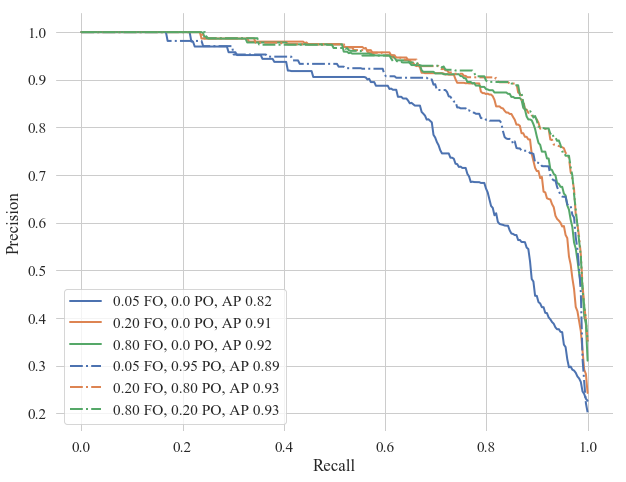

In [44]:
plot_curves(fracs, curves, aps)

### Additional Info

In [45]:
from sklearn.metrics import classification_report

print(classification_report(test_samples[:, -1], scores[-1][1] > 0.7))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4779
         1.0       0.85      0.87      0.86       221

   micro avg       0.99      0.99      0.99      5000
   macro avg       0.92      0.93      0.93      5000
weighted avg       0.99      0.99      0.99      5000

